# Walkthrough Agent Demo

Transform tutorial videos into **interactive AI-guided walkthroughs** using Azure AI.

## Pipeline Overview

| Stage | What Happens | Azure Service |
|-------|--------------|---------------|
| **1. Setup** | Configure Azure credentials | Azure Identity |
| **2. Video Ingestion** | Load video file | Local |
| **3. Content Understanding** | Extract segments & transcripts | Azure AI Content Understanding |
| **4. Walkthrough Extraction** | Create structured steps | Azure AI Agent + Function Calling |
| **5. Screenshots** | Capture frames at timestamps | FFmpeg |
| **6. Interactive Agent** | Chat-based guidance | Azure AI Agent + Multi-tool |

---
## 📦 Part 1: Setup & Dependencies

Install required packages and configure Azure credentials.

In [1]:
# Install dependencies
!pip install -q azure-ai-projects --pre azure-identity openai python-dotenv requests

In [2]:
import os
import json
import time
import uuid
import base64
import tempfile
import subprocess
from pathlib import Path
from dataclasses import dataclass
from datetime import datetime, UTC

import requests
from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from azure.ai.projects.models import PromptAgentDefinition, FunctionTool, Tool
from openai.types.responses.response_input_param import FunctionCallOutput
from dotenv import load_dotenv
from IPython.display import display, Image

load_dotenv()

# Configuration
PROJECT_ENDPOINT = os.environ["PROJECT_ENDPOINT"]
CONTENT_UNDERSTANDING_ENDPOINT = os.environ["CONTENT_UNDERSTANDING_ENDPOINT"].rstrip("/")
MODEL_DEPLOYMENT_NAME = os.environ.get("MODEL_DEPLOYMENT_NAME", "gpt-4o-mini")
API_VERSION = "2024-12-01-preview"

print(f"✅ Project: {PROJECT_ENDPOINT[:5]}...")
print(f"✅ Content Understanding: {CONTENT_UNDERSTANDING_ENDPOINT[:5]}...")
print(f"✅ Model: {MODEL_DEPLOYMENT_NAME}")

✅ Project: https...
✅ Content Understanding: https...
✅ Model: gpt-4.1-mini


---
## 🎥 Part 2: Video Ingestion

Load a video file to analyze. Place your video in the `uploads/` folder or specify the path directly.

In [3]:
# Find video in uploads folder (or set VIDEO_PATH manually)
UPLOADS_DIR = Path("uploads")
UPLOADS_DIR.mkdir(exist_ok=True)

video_files = list(UPLOADS_DIR.glob("*.mp4")) + list(UPLOADS_DIR.glob("*.webm")) + list(UPLOADS_DIR.glob("*.mov"))
VIDEO_PATH = video_files[0] if video_files else Path("uploads/your_video.mp4")

print(f"📹 Video: {VIDEO_PATH}")

📹 Video: uploads/your_video.mp4


In [4]:
# Load the video
video_data = VIDEO_PATH.read_bytes()
print(f"✅ Video loaded: {len(video_data)/1024/1024:.2f} MB")

✅ Video loaded: 14.66 MB


---
## 🔍 Part 3: Azure Content Understanding

Content Understanding automatically:
- **Segments** the video by scene changes
- **Transcribes** speech to text
- **Generates descriptions** of what's happening

### The Analyzer Template

In [5]:
# Data models
@dataclass
class VideoSegment:
    segment_id: str
    start_time_ms: int
    end_time_ms: int
    transcript: str
    description: str

@dataclass
class VideoAnalysisResult:
    segments: list
    full_transcript: str
    duration_ms: int

# Content Understanding analyzer template - this tells Azure what to extract
ANALYZER_TEMPLATE = {
    "description": "Tutorial video analyzer",
    "scenario": "videoShot",  # Automatic scene detection
    "config": {
        "locales": ["en-US"],
        "returnDetails": True,
        "enableFace": False,
        "segmentationMode": "auto",
    },
    "fieldSchema": {
        "fields": {
            "actionDescription": {
                "type": "string",
                "method": "generate",
                "description": "What action is being demonstrated"
            }
        }
    }
}

print("📋 Analyzer template configured")

📋 Analyzer template configured


In [6]:
# Azure authentication helper
def get_auth_headers():
    credential = DefaultAzureCredential()
    token = credential.get_token("https://cognitiveservices.azure.com/.default")
    return {"Authorization": f"Bearer {token.token}", "Content-Type": "application/json"}

# Poll async operations
def poll_operation(response, timeout=600):
    location = response.headers.get("operation-location")
    if not location:
        return response.json()
    
    start = time.time()
    while time.time() - start < timeout:
        result = requests.get(location, headers=get_auth_headers()).json()
        status = result.get("status", "").lower()
        if status == "succeeded":
            return result
        print(f"   ⏳ {status}...")
        time.sleep(5)

# Parse Content Understanding response
def parse_analysis_result(raw):
    contents = raw.get("result", {}).get("contents", [])
    segments = []
    transcripts = []
    
    for idx, content in enumerate(contents):
        transcript = " ".join(p.get("text", "") for p in content.get("transcriptPhrases", []))
        fields = content.get("fields", {})
        
        segments.append(VideoSegment(
            segment_id=f"seg_{idx}",
            start_time_ms=content.get("startTimeMs", 0),
            end_time_ms=content.get("endTimeMs", 0),
            transcript=transcript,
            description=fields.get("actionDescription", {}).get("valueString", ""),
        ))
        if transcript:
            transcripts.append(transcript)
    
    segments.sort(key=lambda s: s.start_time_ms)
    duration = max((s.end_time_ms for s in segments), default=0)
    
    return VideoAnalysisResult(segments=segments, full_transcript=" ".join(transcripts), duration_ms=duration)

print("✅ Helper functions ready")

✅ Helper functions ready


In [7]:
def analyze_video(video_bytes):
    """Analyze video with Azure Content Understanding."""
    analyzer_id = f"demo_{uuid.uuid4().hex[:8]}"
    
    # Create analyzer
    print(f"📋 Creating analyzer: {analyzer_id}")
    resp = requests.put(
        f"{CONTENT_UNDERSTANDING_ENDPOINT}/contentunderstanding/analyzers/{analyzer_id}?api-version={API_VERSION}",
        headers=get_auth_headers(),
        json=ANALYZER_TEMPLATE
    )
    poll_operation(resp, timeout=60)
    
    # Submit video for analysis
    print(f"🎬 Analyzing video...")
    headers = get_auth_headers()
    headers["Content-Type"] = "application/octet-stream"
    resp = requests.post(
        f"{CONTENT_UNDERSTANDING_ENDPOINT}/contentunderstanding/analyzers/{analyzer_id}:analyze?api-version={API_VERSION}",
        headers=headers,
        data=video_bytes
    )
    raw_result = poll_operation(resp, timeout=600)
    
    # Cleanup analyzer
    requests.delete(f"{CONTENT_UNDERSTANDING_ENDPOINT}/contentunderstanding/analyzers/{analyzer_id}?api-version={API_VERSION}", headers=get_auth_headers())
    
    return parse_analysis_result(raw_result)

In [9]:
# Run video analysis
video_analysis = analyze_video(video_data)

print(f"\n✅ Analysis complete!")
print(f"   Duration: {video_analysis.duration_ms / 1000:.1f}s")
print(f"   Segments: {len(video_analysis.segments)}")

📋 Creating analyzer: demo_5396e12d
🎬 Analyzing video...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...
   ⏳ running...

✅ Analysis complete!
   Duration: 760.3s
   Segments: 46


In [10]:
# View extracted segments
for seg in video_analysis.segments:
    print(f"[{seg.start_time_ms/1000:.1f}s] {seg.description[:80]}")

[0.0s] The segment appears to be an introduction or title sequence for 'Inside Microsof
[3.4s] Introduction to the Newfoundry portal, highlighting the welcome screen with proj
[36.0s] Navigating to the model catalog via the Discover tab and exploring available mod
[58.7s] Viewing and sorting models in the Microsoft Foundry portal.
[62.8s] Introduction to the model catalog interface. Explanation of how to expand the vi
[71.9s] Explanation of the sorting and filtering options available for models, including
[99.4s] Further filtering options explained, including inference tasks and fine-tuning m
[122.1s] The video shows a list of models available for selection, including GPT-5.1. The
[125.1s] Upon selecting a model, the video transitions to the model card for GPT-5.1. The
[154.7s] The video highlights 'quick facts' about the model, such as provider, type, life
[181.5s] Discussion about other models and tools used with GPT-5.1, including Model Route
[204.0s] Explanation of project resource

---
## 📝 Part 4: Walkthrough Extraction with Function Calling

Now we use an LLM to transform raw segments into **clean, structured steps**.

The key technique is **function calling** - we define a JSON schema and force the model to output structured data.

In [28]:
# Data models
@dataclass
class WalkthroughStep:
    step_number: int
    title: str
    description: str
    timestamp_ms: int
    screenshot_base64: str = None

@dataclass
class Walkthrough:
    id: str
    title: str
    description: str
    steps: list
    video_duration_ms: int

# Define the function tool for structured extraction
provide_walkthrough_tool = FunctionTool(
    name="provide_walkthrough",
    description="Provide the extracted walkthrough steps from the video.",
    parameters={
        "type": "object",
        "properties": {
            "title": {"type": "string", "description": "Clear title for this walkthrough"},
            "description": {"type": "string", "description": "What this walkthrough teaches"},
            "steps": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "step_number": {"type": "integer"},
                        "title": {"type": "string"},
                        "description": {"type": "string"},
                        "timestamp_ms": {"type": "integer"},
                    },
                    "required": ["step_number", "title", "description", "timestamp_ms"],
                    "additionalProperties": False,
                }
            }
        },
        "required": ["title", "description", "steps"],
        "additionalProperties": False,
    },
    strict=True
)

print("📋 Walkthrough extraction tool defined")

📋 Walkthrough extraction tool defined


In [29]:
# Initialize Azure AI Project client
project_client = AIProjectClient(
    endpoint=PROJECT_ENDPOINT,
    credential=DefaultAzureCredential(),
)

# Create an agent for walkthrough extraction
extraction_agent = project_client.agents.create_version(
    agent_name="WalkthroughExtractor",
    definition=PromptAgentDefinition(
        model=MODEL_DEPLOYMENT_NAME,
        instructions="""You extract step-by-step guides from tutorial videos.
Given video segments with transcripts and descriptions, create a structured walkthrough.
- Each step should be a single action
- Include timestamps so users can find the exact moment
- Be concise but complete
You MUST call the 'provide_walkthrough' function with your results.""",
        tools=[provide_walkthrough_tool],
    ),
)

openai_client = project_client.get_openai_client()
print(f"✅ Extraction agent created: {extraction_agent.name} (v{extraction_agent.version})")

✅ Extraction agent created: WalkthroughExtractor (v2)


In [17]:
def extract_walkthrough(analysis_result):
    """Extract structured walkthrough using the agent with function calling."""
    
    # Build prompt from segments
    segments_text = "\n\n".join([
        f"[{s.start_time_ms}ms - {s.end_time_ms}ms]\nDescription: {s.description}\nTranscript: {s.transcript[:500]}"
        for s in analysis_result.segments
    ])
    
    prompt = f"""Analyze this tutorial video and extract a step-by-step walkthrough.
Video Duration: {analysis_result.duration_ms}ms

Segments:
{segments_text}

Call the provide_walkthrough function with your extracted steps."""

    # Call agent
    response = openai_client.responses.create(
        input=prompt,
        extra_body={"agent": {"name": extraction_agent.name, "type": "agent_reference"}},
    )
    
    # Process function call
    for item in response.output:
        if item.type == "function_call" and item.name == "provide_walkthrough":
            result = json.loads(item.arguments)
            
            # Provide the function output back to complete the call
            openai_client.responses.create(
                input=[FunctionCallOutput(type="function_call_output", call_id=item.call_id, output=json.dumps({"status": "success"}))],
                previous_response_id=response.id,
                extra_body={"agent": {"name": extraction_agent.name, "type": "agent_reference"}},
            )
            
            # Build walkthrough
            walkthrough_id = uuid.uuid4().hex[:12]
            steps = [
                WalkthroughStep(
                    step_number=s["step_number"],
                    title=s["title"],
                    description=s["description"],
                    timestamp_ms=s["timestamp_ms"],
                )
                for s in result.get("steps", [])
            ]
            
            return Walkthrough(
                id=walkthrough_id,
                title=result.get("title", "Untitled"),
                description=result.get("description", ""),
                steps=steps,
                video_duration_ms=analysis_result.duration_ms,
            )

print("✅ extract_walkthrough() ready")

✅ extract_walkthrough() ready


In [18]:
# Extract the walkthrough
walkthrough = extract_walkthrough(video_analysis)

print(f"📖 {walkthrough.title}")
print(f"   {walkthrough.description}")
print(f"   {len(walkthrough.steps)} steps extracted")

📖 How to Deploy and Use Models in Microsoft Foundry Portal
   This walkthrough details the step-by-step process of deploying, exploring, comparing, and interacting with AI models within the Microsoft Foundry portal, as shown in the tutorial video.
   30 steps extracted


---
## 📸 Part 5: Screenshot Extraction with FFmpeg

Extract frames from the video at each step's timestamp to show users what they should see.

In [19]:
# Screenshot extraction with FFmpeg
def extract_frame(video_path, timestamp_ms, output_path):
    """Extract a single frame from video."""
    cmd = [
        "ffmpeg", "-y", "-ss", str(timestamp_ms / 1000.0),
        "-i", str(video_path), "-vframes", "1", "-q:v", "2", str(output_path)
    ]
    subprocess.run(cmd, capture_output=True, timeout=30)
    return output_path

def extract_screenshots(video_path, steps):
    """Extract screenshots for all steps."""
    screenshots = {}
    with tempfile.TemporaryDirectory() as temp_dir:
        for step in steps:
            frame_path = Path(temp_dir) / f"step_{step.step_number}.jpg"
            extract_frame(video_path, step.timestamp_ms, frame_path)
            if frame_path.exists() and frame_path.stat().st_size > 0:
                screenshots[step.step_number] = base64.b64encode(frame_path.read_bytes()).decode()
                print(f"   ✅ Step {step.step_number}")
    return screenshots

print("✅ Screenshot functions ready")

✅ Screenshot functions ready


In [20]:
# Extract screenshots
print("📸 Extracting screenshots...")
screenshots = extract_screenshots(VIDEO_PATH, walkthrough.steps)

# Add to steps
for step in walkthrough.steps:
    step.screenshot_base64 = screenshots.get(step.step_number)

print(f"✅ {len(screenshots)} screenshots captured")

📸 Extracting screenshots...
   ✅ Step 1
   ✅ Step 2
   ✅ Step 3
   ✅ Step 4
   ✅ Step 5
   ✅ Step 6
   ✅ Step 7
   ✅ Step 8
   ✅ Step 9
   ✅ Step 10
   ✅ Step 11
   ✅ Step 12
   ✅ Step 13
   ✅ Step 14
   ✅ Step 15
   ✅ Step 16
   ✅ Step 17
   ✅ Step 18
   ✅ Step 19
   ✅ Step 20
   ✅ Step 21
   ✅ Step 22
   ✅ Step 23
   ✅ Step 24
   ✅ Step 25
   ✅ Step 26
   ✅ Step 27
   ✅ Step 28
   ✅ Step 29
   ✅ Step 30
✅ 30 screenshots captured


═══════════════════════════════════════════
📖 How to Deploy and Use Models in Microsoft Foundry Portal
═══════════════════════════════════════════

Step 1: Verify Newfoundry Portal Access
   Ensure you are in the Newfoundry portal by checking the toggle at the top. It should be set to the far right to confirm you are in the new Foundry experience, not the classic Foundry portal.


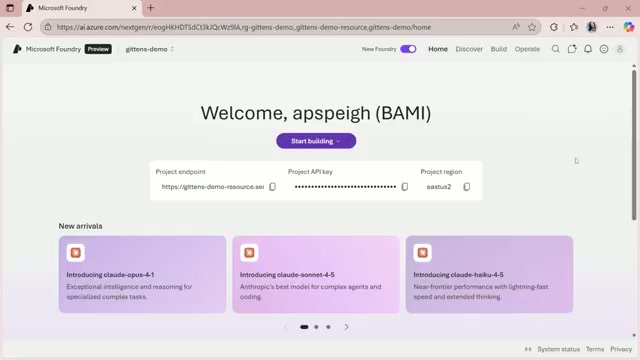


Step 2: Navigate to the Model Catalog
   Select 'Discover' in the top menu, then click 'Models' on the far left to access the model catalog within the Newfoundry portal.


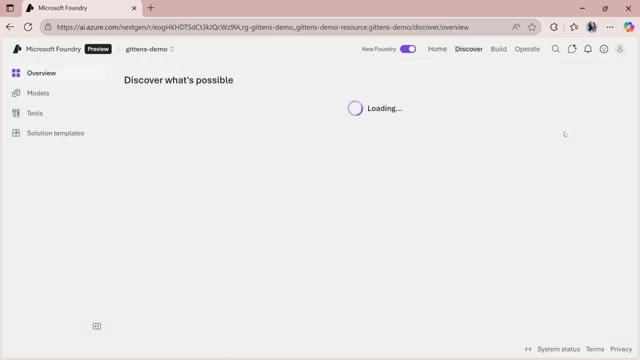


Step 3: Expand the Model Catalog View
   Click the left arrow icon at the bottom to expand the model catalog view, allowing you to see more models available in the portal.


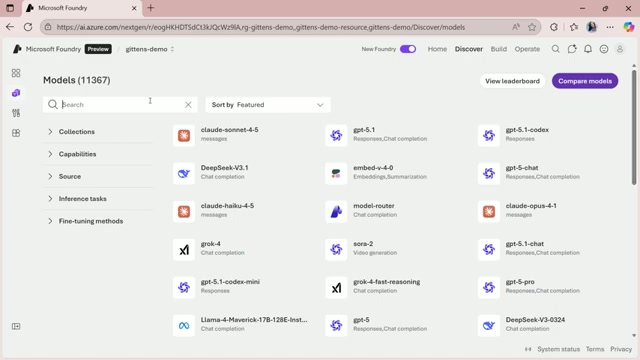


Step 4: Search and Sort Models
   Use the search bar to find models by name and sort them by featured, newest, or recently updated to filter and organize models effectively.


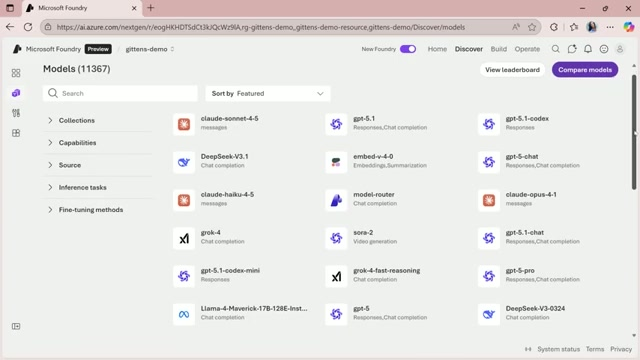


Step 5: Apply Model Filters
   Filter models by category (e.g., direct from Azure or Foundry Labs), source (e.g., Anthropic or Hugging Face), capabilities (e.g., reasoning, tool calling), inference tasks (e.g., check completion, audio generation), and fine-tuning methods (e.g., direct preference optimization, reinforcement, supervised learning).


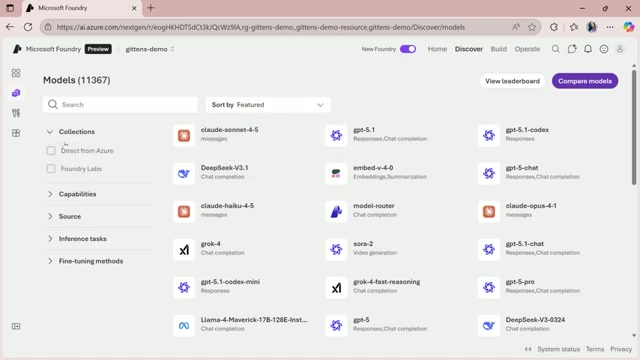


Step 6: View Model Card for Detailed Information
   Select a model (e.g., GPT-5.1) to view its model card with details such as capabilities, pricing, technical specs, training disclosures, and responsible AI considerations.


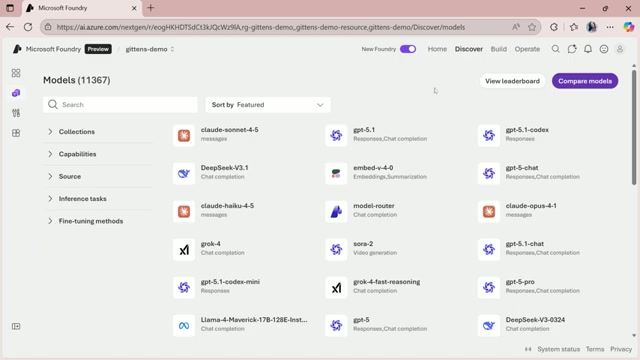


Step 7: Explore Quick Facts and Related Tools on Model Card
   Check the quick facts on the model card including provider, lifecycle, input/output types, and context, along with other related models or tools commonly used with it.


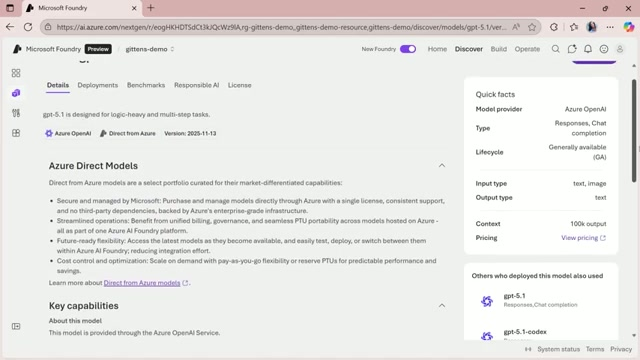


Step 8: Review Benchmarks and Licensing Information
   Look for available benchmarks, licensing details, and responsible AI information within the model card, noting that benchmarks may sometimes be unavailable.


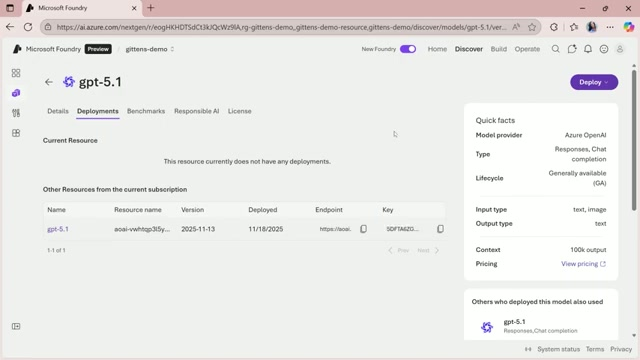


Step 9: Access the Leaderboard to Compare Models
   Open the leaderboard to compare models across quality index, safety, throughput, and estimated cost with pre-selected models displayed by default.


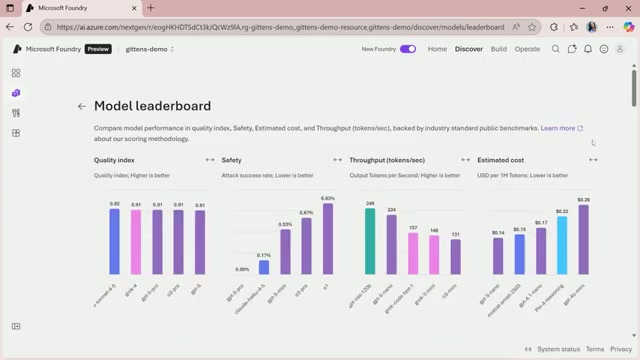


Step 10: Select and Compare Specific Models
   Scroll below the leaderboard charts to select specific models for comparison, such as Claude Sonnet 4.5 and GPT-5 Mini, then click 'Compare Models' to see detailed side-by-side metrics.


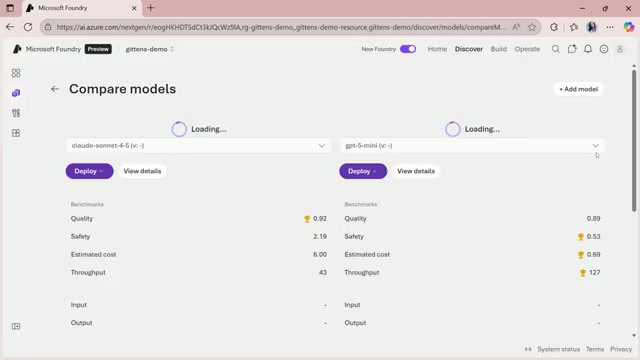


Step 11: Search for a Specific Model to Deploy
   Use the search bar to find a specific model like 'GPT-4.1-mini' in the model catalog to begin deployment.


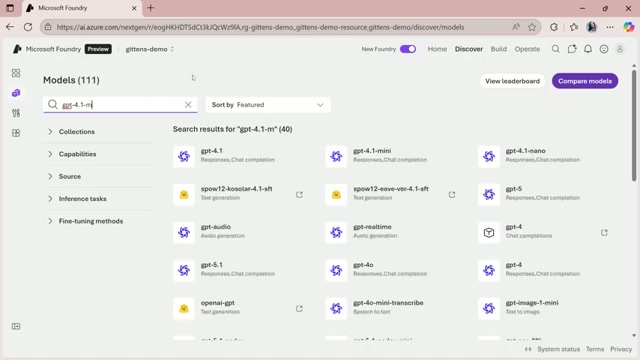


Step 12: Open Model Card for Deployment Options
   Select the model (e.g., GPT-4.1-mini) to access its model card where you can choose to either deploy or fine-tune the model.


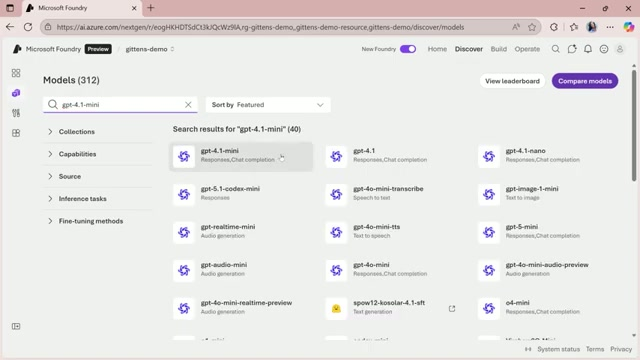


Step 13: Deploy the Model Using Default or Custom Settings
   Choose 'Deploy' and select either default settings (global standards and default quota) or custom settings (custom SKU, quota, PTU, spillover, guardrails) to start deployment.


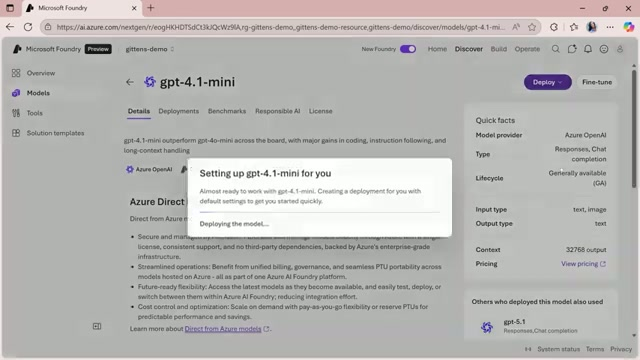


Step 14: Access the Playground to Chat with the Model
   Once deployment completes, enter the Playground interface to start interacting and chatting with the deployed model.


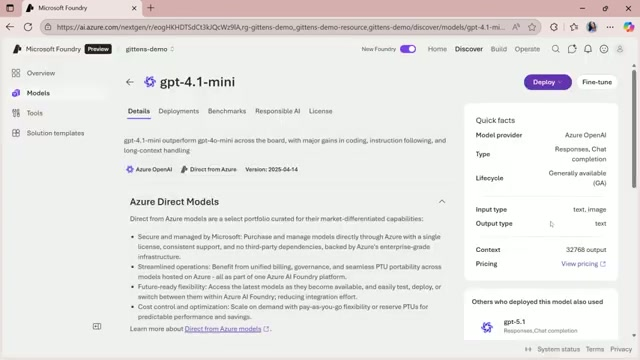


Step 15: Navigate to the Build Models Area
   Use the back arrow to navigate to the 'Models' area under the 'Build' section to view all deployed models within your project.


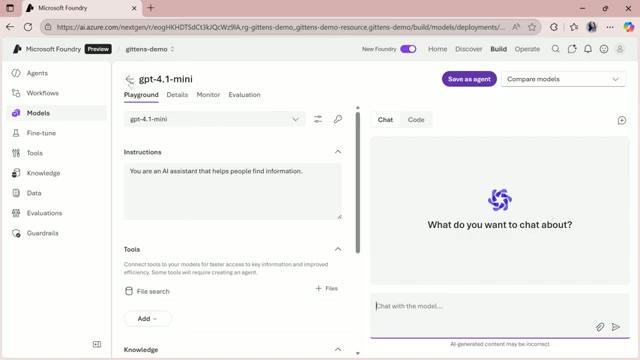


Step 16: View Model Details and Manage Deployment
   Select a deployed model to view its details, edit information, delete the model, request quota, and monitor usage and performance metrics such as requests, token count, and estimated cost.


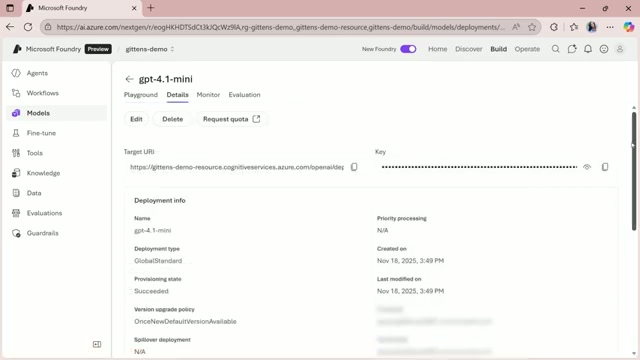


Step 17: Start Evaluations and Provide Chat Instructions
   Under the model's Playground tab, start chatting with the model and modify default instructions or add evaluations as needed.


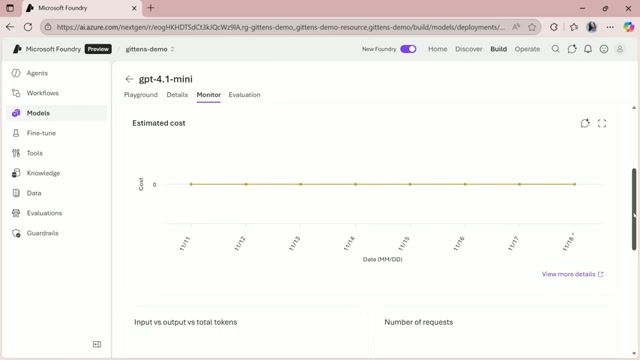


Step 18: Add Foundry Tools, Knowledge, Memory, and Guardrails
   Enhance model performance by adding Foundry tools, grounding the model with specific knowledge, enabling memory retention, and applying guardrails to control output behavior.


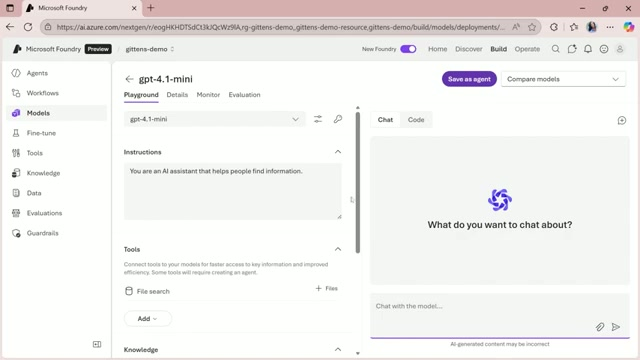


Step 19: Submit Prompts and View Model Output
   Type and submit prompts to the model, attach compatible files if supported, and review the generated output along with details like response time, token usage, and model version.


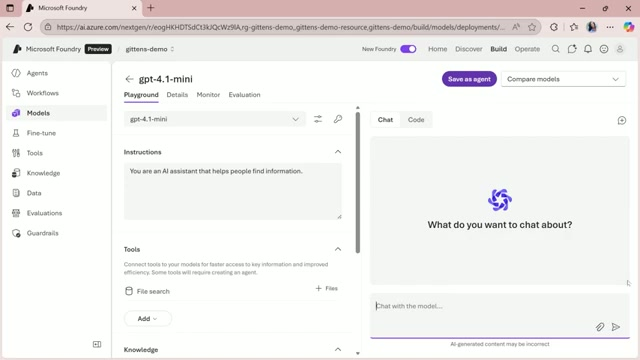


Step 20: Start a New Chat and Compare Model Responses
   Begin a new conversation by selecting the 'New Chat' button, and compare responses side-by-side from multiple deployed models in separate chat windows.


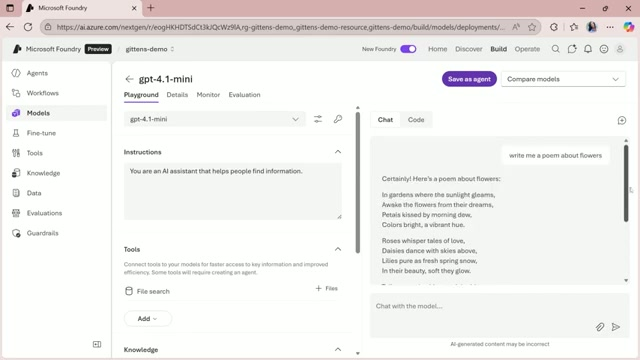


Step 21: Deploy Additional Models Like GPT-4.0
   Deploy other models such as GPT-4.0 to enable comparison and multi-model interaction in the chat interface.


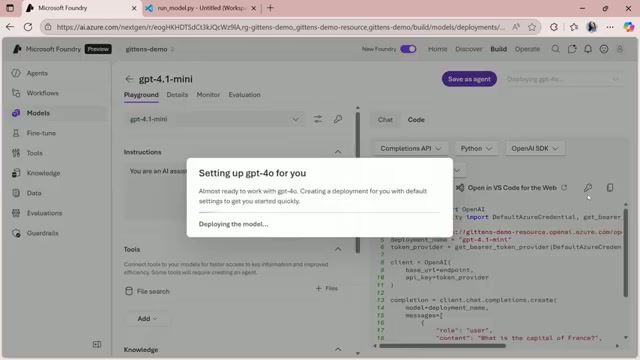


Step 22: Provide Instructions in Setup Tab for Chat Behavior
   Use the 'Setup' tab to define instructions and configure settings affecting model behavior during chat sessions.


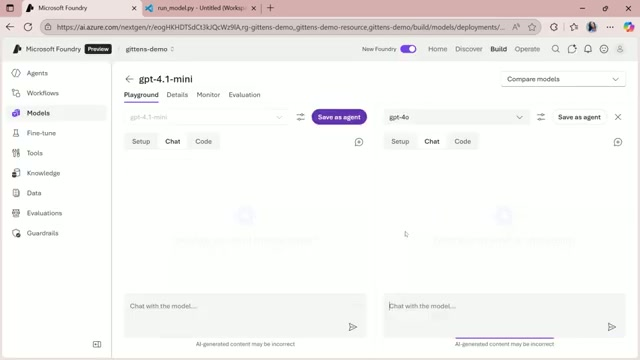


Step 23: Observe Comparative Performance Between Models
   Submit a prompt and observe differences in response speed, token counts, and output quality between models like GPT-4.1 mini and GPT-4.0.


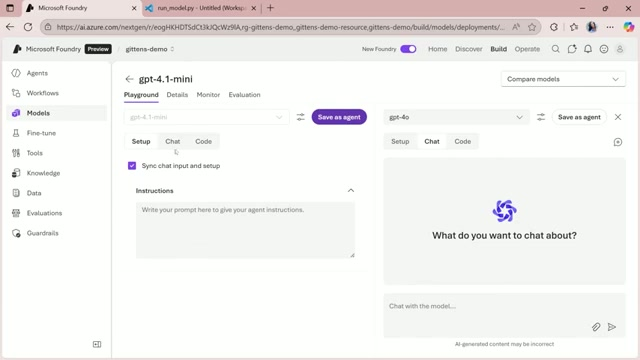


Step 24: Access Code Generation Tab for API and Language Selection
   Switch to the 'Code' tab to generate code snippets for APIs (Completions or Responses) in languages such as Python, JavaScript, C#, Go, Java, or curl.


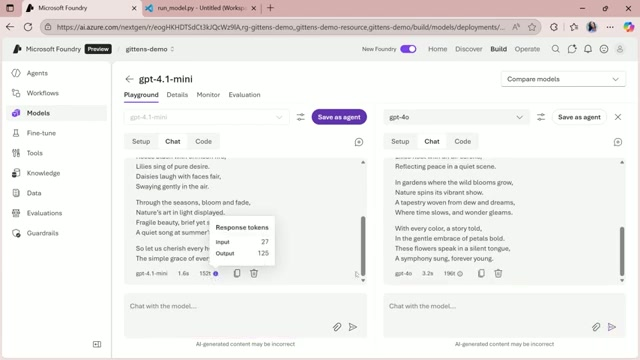


Step 25: Choose SDK and Authentication Method
   Select your SDK (OpenAI SDK or REST) and authentication method (key or recommended EntraID authentication) to avoid hardcoding keys.


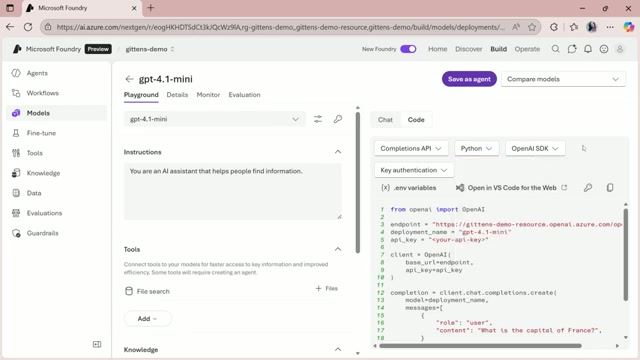


Step 26: Copy Code to Editor or Open in VS Code for Web
   Either copy the generated code into a local code editor like Visual Studio Code, or open the code directly in Visual Studio Code for the Web for immediate use.


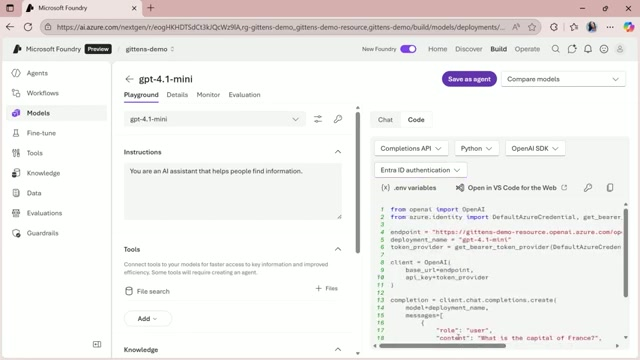


Step 27: Wait for Visual Studio Code Setup in the Web
   Wait approximately 40 seconds while Visual Studio Code for the Web sets up the environment and imports the code for working with your model.


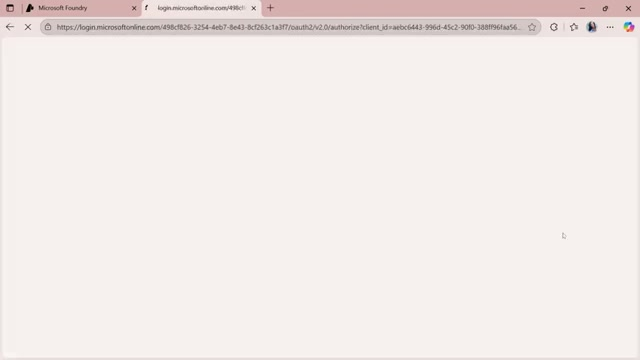


Step 28: Review Code and Dependencies in Visual Studio Code
   Observe the code and watch dependencies download in Visual Studio Code as you prepare to work with the model; optionally use GitHub Copilot assistance.


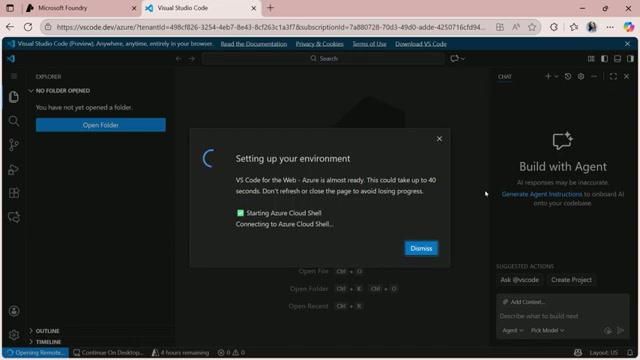


Step 29: Work with the Model in VS Code with Entra ID Authentication
   Utilize the run_model file to interact with the deployed model in VS Code, leveraging Entra ID for secure authentication without hardcoding keys.


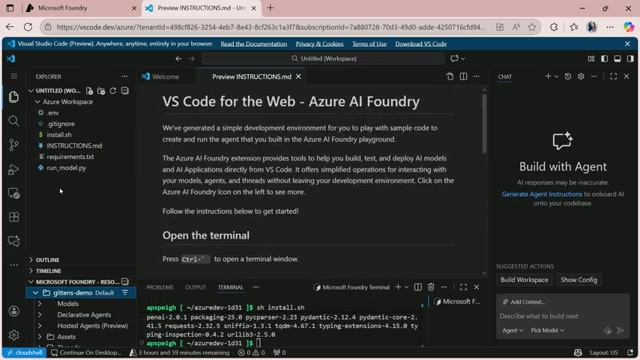


Step 30: Use the Foundry Portal for Model Exploration and Management
   Explore a variety of models, learn about them, compare, and chat with models through the Foundry portal interface for comprehensive model management.


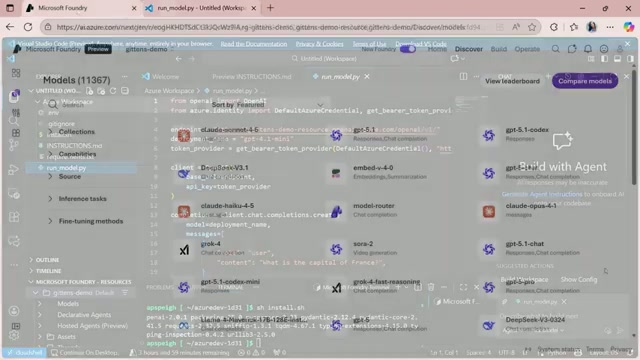

In [21]:
# Display the walkthrough
print(f"═══════════════════════════════════════════")
print(f"📖 {walkthrough.title}")
print(f"═══════════════════════════════════════════\n")

for step in walkthrough.steps:
    print(f"Step {step.step_number}: {step.title}")
    print(f"   {step.description}")
    if step.screenshot_base64:
        display(Image(data=base64.b64decode(step.screenshot_base64), width=400))
    print()

---
## 🤖 Part 6: Interactive Walkthrough Agent

The agent guides users through steps using **multi-tool function calling**:

1. `set_user_state` - Track which step the user is on
2. `get_next_steps_preview` - Get upcoming steps with screenshots
3. `agent_response` - Send structured response to user

In [22]:
# Define agent tools using FunctionTool
set_user_state_tool = FunctionTool(
    name="set_user_state",
    description="Store the user's current progress state.",
    parameters={
        "type": "object",
        "properties": {
            "current_step": {"type": "integer", "description": "Step number (1-based), 0 if unknown"},
            "step_status": {"type": "string", "enum": ["not_started", "in_progress", "completed", "stuck"]},
            "completed_steps": {"type": "array", "items": {"type": "integer"}},
        },
        "required": ["current_step", "step_status", "completed_steps"],
        "additionalProperties": False,
    },
    strict=True
)

get_next_steps_tool = FunctionTool(
    name="get_next_steps_preview",
    description="Get info about the current and upcoming steps.",
    parameters={
        "type": "object",
        "properties": {
            "current_step": {"type": "integer", "description": "Current step number"},
        },
        "required": ["current_step"],
        "additionalProperties": False,
    },
    strict=True
)

agent_response_tool = FunctionTool(
    name="agent_response",
    description="Send your response to the user.",
    parameters={
        "type": "object",
        "properties": {
            "message": {"type": "string", "description": "Your response message"},
            "show_screenshot": {"type": "boolean", "description": "Whether to show the current step screenshot"},
            "suggested_actions": {"type": "array", "items": {"type": "string"}, "description": "2-3 suggested next actions"},
        },
        "required": ["message", "show_screenshot", "suggested_actions"],
        "additionalProperties": False,
    },
    strict=True
)

agent_tools: list[Tool] = [set_user_state_tool, get_next_steps_tool, agent_response_tool]
print("🛠️ Agent tools defined:", [t.name for t in agent_tools])

🛠️ Agent tools defined: ['set_user_state', 'get_next_steps_preview', 'agent_response']


In [52]:
@dataclass
class AgentResponse:
    message: str
    current_step: int
    show_screenshot: bool
    suggested_actions: list
    screenshot_base64: str = None
    user_state: dict = None


class WalkthroughAgent:
    """Interactive agent that guides users through a walkthrough using Azure AI Agents."""
    
    def __init__(self, walkthrough, project_client):
        self.walkthrough = walkthrough
        self.project_client = project_client
        self.openai_client = project_client.get_openai_client()
        
        # Build steps text for instructions
        steps_text = "\n".join([
            f"Step {s.step_number}: {s.title} - {s.description}"
            for s in walkthrough.steps
        ])
        
        # Create the agent
        self.agent = project_client.agents.create_version(
            agent_name=f"WalkthroughGuide-{walkthrough.id}",
            definition=PromptAgentDefinition(
                model=MODEL_DEPLOYMENT_NAME,
                instructions=f"""You are a helpful guide for: {walkthrough.title}

{walkthrough.description}

STEPS:
{steps_text}

TOTAL STEPS: {len(walkthrough.steps)}

WORKFLOW:
1. Determine user's current step → call set_user_state
2. Get context → call get_next_steps_preview  
3. Respond → call agent_response

Be helpful and guide one step at a time.""",
                tools=agent_tools,
            ),
        )
        
        # Create a conversation for multi-turn
        self.conversation = self.openai_client.conversations.create()
    
    def _get_step_preview(self, current_step):
        """Get preview of current and next steps."""
        preview = []
        for s in self.walkthrough.steps:
            if s.step_number >= current_step and s.step_number < current_step + 3:
                preview.append({"step": s.step_number, "title": s.title, "description": s.description})
        return preview
    
    def chat(self, message, user_state=None):
        """Chat with the agent."""
        updated_state = user_state.copy() if user_state else {}
        
        # Send message to agent
        response = self.openai_client.responses.create(
            conversation=self.conversation.id,
            extra_body={"agent": {"name": self.agent.name, "type": "agent_reference"}},
            input=message,
        )
        
        final_response = None
        
        # Process function calls in a loop
        while True:
            function_outputs = []
            
            for item in response.output:
                if item.type == "function_call":
                    print(f"   🛠️ Tool: {item.name}")
                    args = json.loads(item.arguments)
                    
                    if item.name == "set_user_state":
                        updated_state = {
                            "current_step": args.get("current_step", 0),
                            "step_status": args.get("step_status", "not_started"),
                            "completed_steps": args.get("completed_steps", []),
                        }
                        function_outputs.append(FunctionCallOutput(
                            type="function_call_output",
                            call_id=item.call_id,
                            output=json.dumps({"status": "saved"})
                        ))
                    
                    elif item.name == "get_next_steps_preview":
                        preview = self._get_step_preview(args.get("current_step", 1))
                        function_outputs.append(FunctionCallOutput(
                            type="function_call_output",
                            call_id=item.call_id,
                            output=json.dumps({"steps": preview, "total": len(self.walkthrough.steps)})
                        ))
                    
                    elif item.name == "agent_response":
                        # This is the final response
                        current_step = updated_state.get("current_step", 0)
                        screenshot = None
                        if args.get("show_screenshot") and current_step > 0:
                            step = next((s for s in self.walkthrough.steps if s.step_number == current_step), None)
                            if step:
                                screenshot = step.screenshot_base64
                        
                        final_response = AgentResponse(
                            message=args.get("message", ""),
                            current_step=current_step,
                            show_screenshot=args.get("show_screenshot", False),
                            suggested_actions=args.get("suggested_actions", []),
                            screenshot_base64=screenshot,
                            user_state=updated_state,
                        )
                        
                        # Still need to send the output to complete the call
                        function_outputs.append(FunctionCallOutput(
                            type="function_call_output",
                            call_id=item.call_id,
                            output=json.dumps({"delivered": True})
                        ))
                    else:
                        print(f"WARNING: Unknown tool call: {item.name}")
            
            # If we have function outputs, send them back
            if function_outputs:
                response = self.openai_client.responses.create(
                    input=function_outputs,
                    conversation=self.conversation.id,
                    extra_body={"agent": {"name": self.agent.name, "type": "agent_reference"}},
                )
                continue
            
            # If we got a final response, return it
            if final_response:
                return final_response
            
            # If no function calls, use text response
            if response.output_text:
                return AgentResponse(
                    message=response.output_text,
                    current_step=updated_state.get("current_step", 0),
                    show_screenshot=False,
                    suggested_actions=["What's the next step?"],
                    user_state=updated_state,
                )
            
            break

print("✅ WalkthroughAgent class ready")

✅ WalkthroughAgent class ready


In [53]:
# Create the interactive agent
agent = WalkthroughAgent(walkthrough, project_client)
print(f"🤖 Agent ready: {agent.agent.name}")

🤖 Agent ready: WalkthroughGuide-fa48b92c7b3d


In [55]:
# Chat Turn 1 - Start the conversation
print("💬 CONVERSATION\n")

response = agent.chat("Hi! Where should I start?")

print(f"👤 User: Hi! Where should I start?\n")
print(f"🤖 Agent: {response.message}\n")
print(f"📍 Step: {response.current_step}")
print(f"💡 Suggestions: {response.suggested_actions}")

if response.screenshot_base64:
    display(Image(data=base64.b64decode(response.screenshot_base64), width=500))

user_state = response.user_state

💬 CONVERSATION

   🛠️ Tool: set_user_state
   🛠️ Tool: get_next_steps_preview
   🛠️ Tool: agent_response
👤 User: Hi! Where should I start?

🤖 Agent: Let's start with Step 1: Verify Newfoundry Portal Access.

You need to make sure you are in the Newfoundry portal. To confirm, check the toggle at the top of the portal interface. It should be set to the far right, indicating that you are using the new Foundry experience rather than the classic Foundry portal.

Next, you'll move to Step 2 where you navigate to the Model Catalog by selecting 'Discover' from the top menu and clicking 'Models' on the far left.

Would you like help with Step 1 to get started?

📍 Step: 1
💡 Suggestions: ['Help me verify Newfoundry Portal Access', 'Explain Step 2: Navigate to the Model Catalog', 'Explain Step 3: Expand the Model Catalog View']


In [56]:
# Chat Turn 2 - Move to next step
response = agent.chat("Done! What's next?", user_state=user_state)

print(f"👤 User: Done! What's next?\n")
print(f"🤖 Agent: {response.message}\n")
print(f"📍 Step: {response.current_step}")
print(f"💡 Suggestions: {response.suggested_actions}")

if response.screenshot_base64:
    display(Image(data=base64.b64decode(response.screenshot_base64), width=500))

user_state = response.user_state

   🛠️ Tool: set_user_state
   🛠️ Tool: get_next_steps_preview
   🛠️ Tool: agent_response
👤 User: Done! What's next?

🤖 Agent: Great! Now on to Step 2: Navigate to the Model Catalog.

In the Newfoundry portal, select 'Discover' from the top menu. Then, on the left side, click on 'Models'. This will take you to the model catalog where you can explore available AI models.

Would you like to proceed with this step, or would you prefer I explain how to expand the model catalog view in Step 3?

📍 Step: 1
💡 Suggestions: ['Help me navigate to the Model Catalog', 'Explain Step 3: Expand the Model Catalog View', 'Explain Step 4: Search and Sort Models']


In [57]:
# Chat Turn 3 - Ask a question
response = agent.chat("I'm confused, can you explain this step more?", user_state=user_state)

print(f"👤 User: I'm confused, can you explain this step more?\n")
print(f"🤖 Agent: {response.message}\n")
print(f"💡 Suggestions: {response.suggested_actions}")

   🛠️ Tool: agent_response
   🛠️ Tool: set_user_state
👤 User: I'm confused, can you explain this step more?

🤖 Agent: Step 2 involves navigating within the Newfoundry portal to reach the model catalog.

Detailed explanation:
- At the top menu of the Newfoundry portal, you will see several options including one labeled 'Discover'. Click on 'Discover'.
- Once you click 'Discover', look to the far left sidebar within that view.
- In that left sidebar, you'll find an option named 'Models'. Clicking this takes you to the model catalog.

The model catalog is where you can browse, search, and find various AI models available for deployment and use.

If you want, I can provide a screenshot or guide you through it step-by-step.

💡 Suggestions: ['Show me a screenshot of Step 2', 'Help me navigate to the Model Catalog', 'Move to Step 3: Expand the Model Catalog View']


---
## 🔑 Key Patterns

### 1. Azure AI Agents API
```python
agent = project_client.agents.create_version(
    agent_name="MyAgent",
    definition=PromptAgentDefinition(
        model=MODEL_DEPLOYMENT_NAME,
        instructions="...",
        tools=[my_function_tool],
    ),
)
```

### 2. Chat with Agent (Responses API)
```python
response = openai_client.responses.create(
    conversation=conversation.id,
    extra_body={"agent": {"name": agent.name, "type": "agent_reference"}},
    input="User message",
)
```

### 3. Function Calling Loop
```python
for item in response.output:
    if item.type == "function_call":
        result = execute_function(item.name, item.arguments)
        outputs.append(FunctionCallOutput(call_id=item.call_id, output=result))

response = openai_client.responses.create(
    input=outputs,
    previous_response_id=response.id,
    extra_body={"agent": {...}},
)
```

### 4. Multi-turn Conversations
```python
conversation = openai_client.conversations.create()
# Use conversation.id in subsequent calls for context
```

---
## 🎯 Complete Pipeline Function

Here's a helper that runs the entire pipeline in one call:

In [ ]:
def create_walkthrough_from_video(video_path):
    """Complete pipeline: Video → Analysis → Walkthrough → Agent"""
    video_path = Path(video_path)
    print(f"🎬 Processing: {video_path}\n")
    
    video_bytes = video_path.read_bytes()
    print(f"✅ 1. Video loaded ({len(video_bytes)/1024/1024:.1f} MB)")
    
    analysis = analyze_video(video_bytes)
    print(f"✅ 2. Analyzed ({len(analysis.segments)} segments)")
    
    wt = extract_walkthrough(analysis)
    print(f"✅ 3. Walkthrough extracted ({len(wt.steps)} steps)")
    
    screenshots = extract_screenshots(video_path, wt.steps)
    for step in wt.steps:
        step.screenshot_base64 = screenshots.get(step.step_number)
    print(f"✅ 4. Screenshots captured")
    
    agent = WalkthroughAgent(wt, project_client)
    print(f"✅ 5. Agent ready: {agent.agent.name}")
    
    return wt, agent

# Usage: walkthrough, agent = create_walkthrough_from_video("uploads/tutorial.mp4")
print("💡 create_walkthrough_from_video(path) runs the full pipeline")

---
## 🏁 Summary

**Pipeline:** `Video → Content Understanding → Agent Extraction → Screenshots → Interactive Agent`

**Azure Services:**
- Azure AI Content Understanding (video segmentation + transcription)
- Azure AI Agents (function calling for structured output)
- Azure AI Conversations (multi-turn context)

**Key APIs:**
- `project_client.agents.create_version()` - Create an agent
- `openai_client.responses.create()` - Chat with agent
- `openai_client.conversations.create()` - Multi-turn conversations
- `FunctionCallOutput` - Return function results to agent